In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bq_helper
import cartopy
import cartopy.crs as ccrs
from bq_helper import BigQueryHelper

In [2]:
#creating the gsod database
noaa_gsod = bq_helper.BigQueryHelper(active_project= "bigquery-public-data", 
                                     dataset_name= "noaa_gsod")


In [3]:
#looking at the available tables
bq_assistant = BigQueryHelper("bigquery-public-data", "noaa_gsod")

bq_assistant.list_tables()

['gsod1929',
 'gsod1930',
 'gsod1931',
 'gsod1932',
 'gsod1933',
 'gsod1934',
 'gsod1935',
 'gsod1936',
 'gsod1937',
 'gsod1938',
 'gsod1939',
 'gsod1940',
 'gsod1941',
 'gsod1942',
 'gsod1943',
 'gsod1944',
 'gsod1945',
 'gsod1946',
 'gsod1947',
 'gsod1948',
 'gsod1949',
 'gsod1950',
 'gsod1951',
 'gsod1952',
 'gsod1953',
 'gsod1954',
 'gsod1955',
 'gsod1956',
 'gsod1957',
 'gsod1958',
 'gsod1959',
 'gsod1960',
 'gsod1961',
 'gsod1962',
 'gsod1963',
 'gsod1964',
 'gsod1965',
 'gsod1966',
 'gsod1967',
 'gsod1968',
 'gsod1969',
 'gsod1970',
 'gsod1971',
 'gsod1972',
 'gsod1973',
 'gsod1974',
 'gsod1975',
 'gsod1976',
 'gsod1977',
 'gsod1978',
 'gsod1979',
 'gsod1980',
 'gsod1981',
 'gsod1982',
 'gsod1983',
 'gsod1984',
 'gsod1985',
 'gsod1986',
 'gsod1987',
 'gsod1988',
 'gsod1989',
 'gsod1990',
 'gsod1991',
 'gsod1992',
 'gsod1993',
 'gsod1994',
 'gsod1995',
 'gsod1996',
 'gsod1997',
 'gsod1998',
 'gsod1999',
 'gsod2000',
 'gsod2001',
 'gsod2002',
 'gsod2003',
 'gsod2004',
 'gsod2005',

In [8]:
#defining the query to grab the station table
#the station table has multiples of the same station for lats and longs that 
#are relatively close. 
#I averaged over them so that the stations are unique
query1 = """
            SELECT 
                usaf AS Station_number, 
                lat AS Latitude, 
                lon AS Longitude, 
            FROM 
                `bigquery-public-data.noaa_gsod.stations` 
            WHERE 
                country = 'US' AND lat IS NOT NULL AND lon IS NOT NULL AND NOT (lat = 0.0 AND lon = 0.0) AND NOT usaf = '999999' 
        """

In [200]:
#The commented portion would give all the stations, including repeated ones
#stations = noaa_gsod.query_to_pandas_safe(query1, max_gb_scanned=10)
stations1 = noaa_gsod.query_to_pandas_safe(query1, max_gb_scanned=10)
stations = stations1.copy()
stations = stations.drop(stations.loc[stations.Station_number.duplicated(keep='last')].index)

In [201]:
def gsodquery(year):
    var2 = 'bigquery-public-data.noaa_gsod.gsod'+str(year)
    query = f"""
            SELECT 
                stn AS Station_number, 
                year AS Year, 
                mo AS Month, 
                AVG(temp) as Mean_temp
            FROM 
                {var2} 
            WHERE 
                Stn in {var}
            GROUP BY
                stn, 
                year, 
                mo
        """
    return query

In [202]:
var = tuple(stations.Station_number)

In [203]:
gsod1950 = noaa_gsod.query_to_pandas_safe(gsodquery(1950), max_gb_scanned=10)

In [204]:
gsod1970 = noaa_gsod.query_to_pandas_safe(gsodquery(1970), max_gb_scanned=10)

In [205]:
gsod1990 = noaa_gsod.query_to_pandas_safe(gsodquery(1990), max_gb_scanned=10)

In [206]:
gsod2000 = noaa_gsod.query_to_pandas_safe(gsodquery(2000), max_gb_scanned=10)

In [207]:
gsod2020 = noaa_gsod.query_to_pandas_safe(gsodquery(2020), max_gb_scanned=10)

In [208]:
def latlong(gsod,stations):
    
    lat = np.empty(len(gsod.Station_number))
    long = np.empty(len(gsod.Station_number))
    gsod_copy = gsod.copy()
    for i in range(len(gsod.Station_number)):
        lat[i] = np.array(stations.loc[stations.Station_number == gsod.Station_number[i]].Latitude)[0]
        long[i] = np.array(stations.loc[stations.Station_number == gsod.Station_number[i]].Longitude)[0]
    gsod_copy['Latitude'] = lat
    gsod_copy['Longitude'] = long
    return gsod_copy

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

    
def mapplot(df,title):
    ccrs.PlateCarree()
    plt.figure(figsize=(30,30))
    central_lat = 37.5
    central_lon = -96
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    extent = [-130, -65, 24, 50.5]
    ax.set_extent(extent)
    ax.add_feature(cartopy.feature.STATES)
    plt.title(title, fontsize=48)
    plt.scatter(df['Longitude'],df['Latitude'], 200, c=df['Mean_temp'], cmap='jet')
    cbar= plt.colorbar(fraction = 0.02)
    cbar.set_label("Temperature", labelpad=+1, fontsize = 20)
   
            
            
            
            

In [209]:
gsod1950ll = latlong(gsod1950,stations)

In [210]:
gsod1950m1 = gsod1950ll.loc[gsod1950ll.Month == '01']

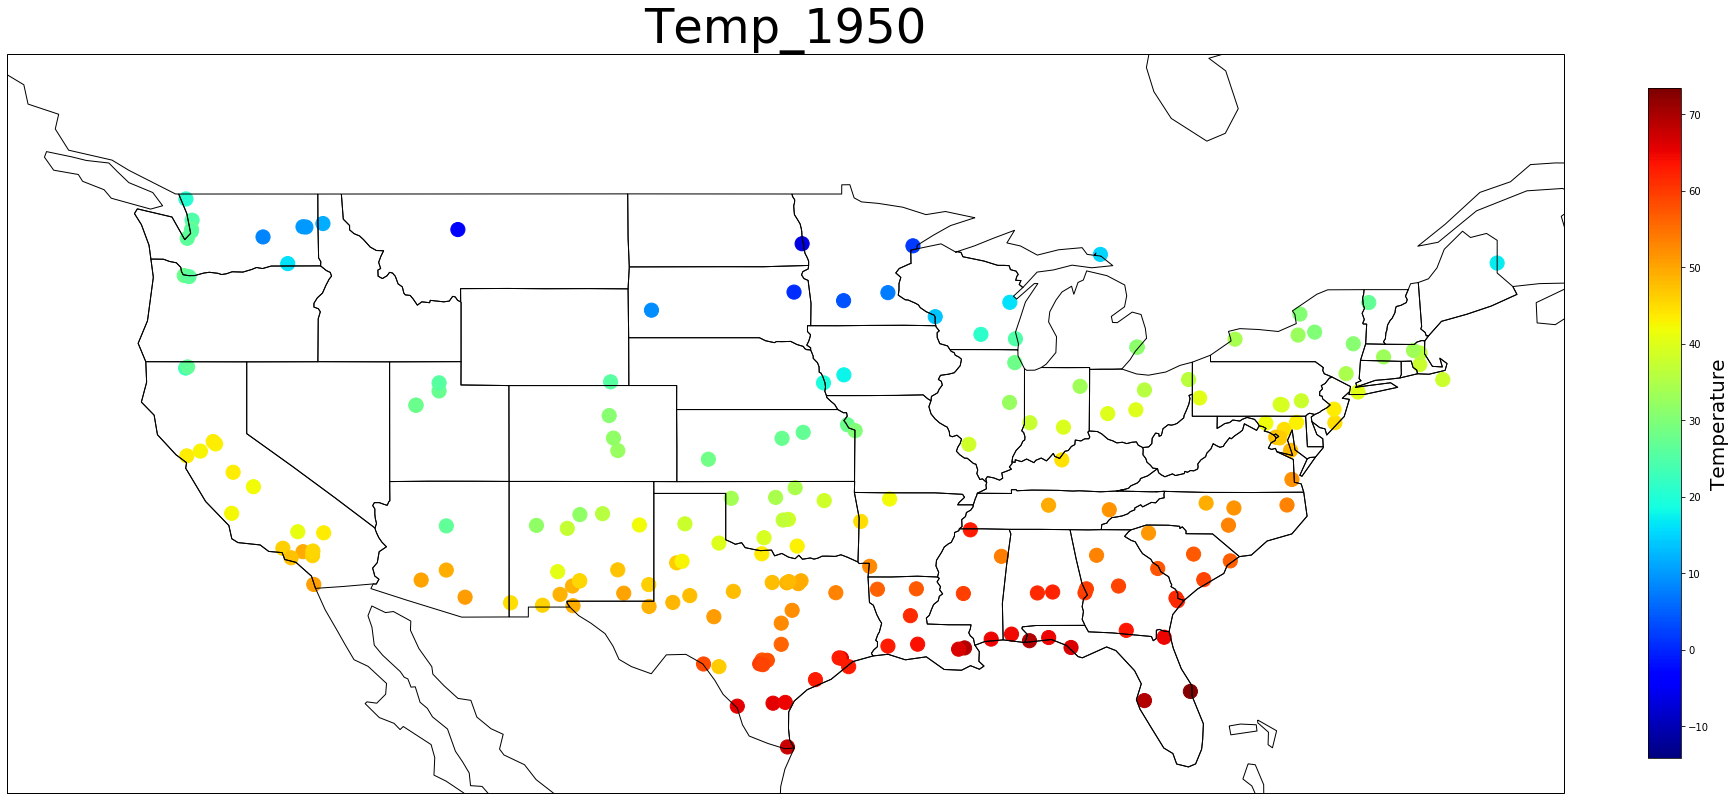

In [211]:
mapplot(gsod1950m1,'Temp_1950')

In [212]:
gsod1970ll = latlong(gsod1970,stations)

In [213]:
gsod1970m1 = gsod1970ll.loc[gsod1970ll.Month == '01']

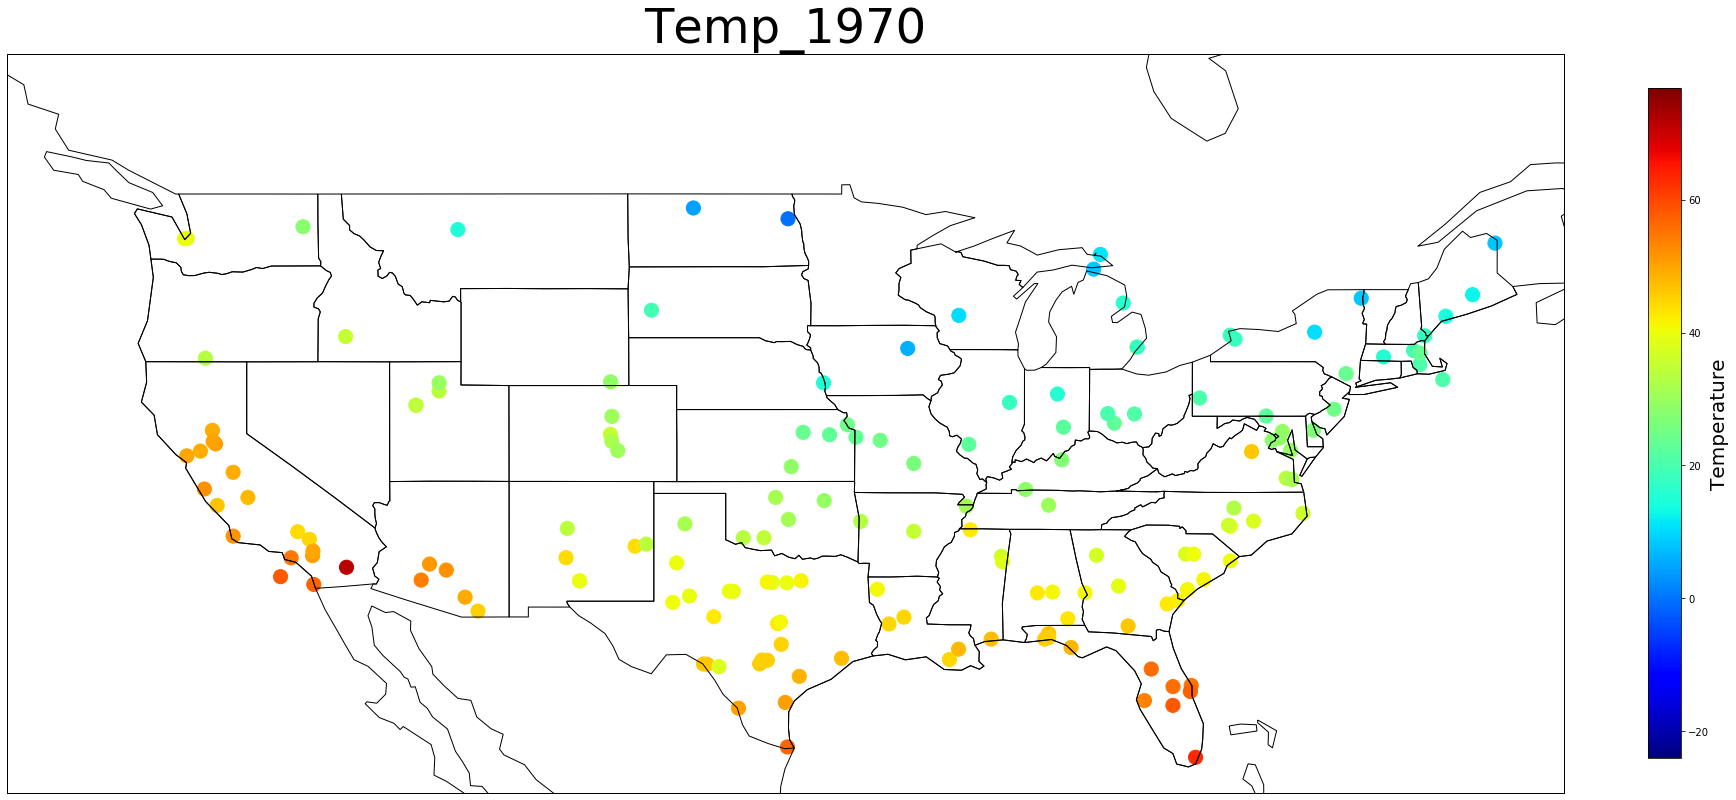

In [214]:
mapplot(gsod1970m1, 'Temp_1970')

In [215]:
gsod1990ll = latlong(gsod1990,stations)

In [216]:
gsod1990m1 = gsod1990ll.loc[gsod1990ll.Month == '01']

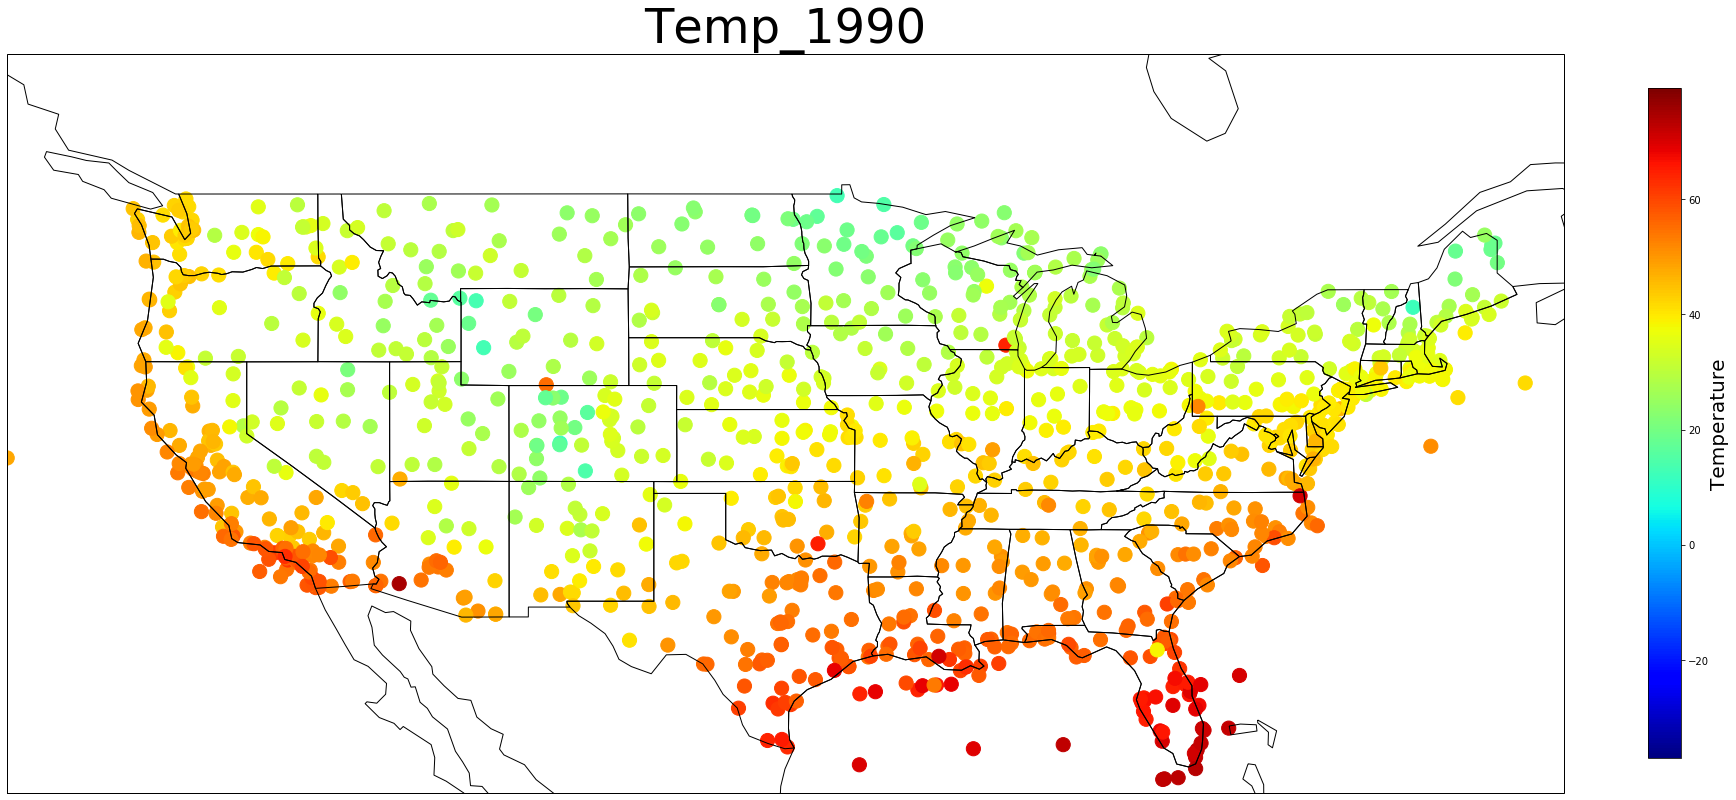

In [217]:
mapplot(gsod1990m1, 'Temp_1990')

In [218]:
gsod2000ll = latlong(gsod2000,stations)

In [219]:
gsod2000m1 = gsod2000ll.loc[gsod2000ll.Month == '02']

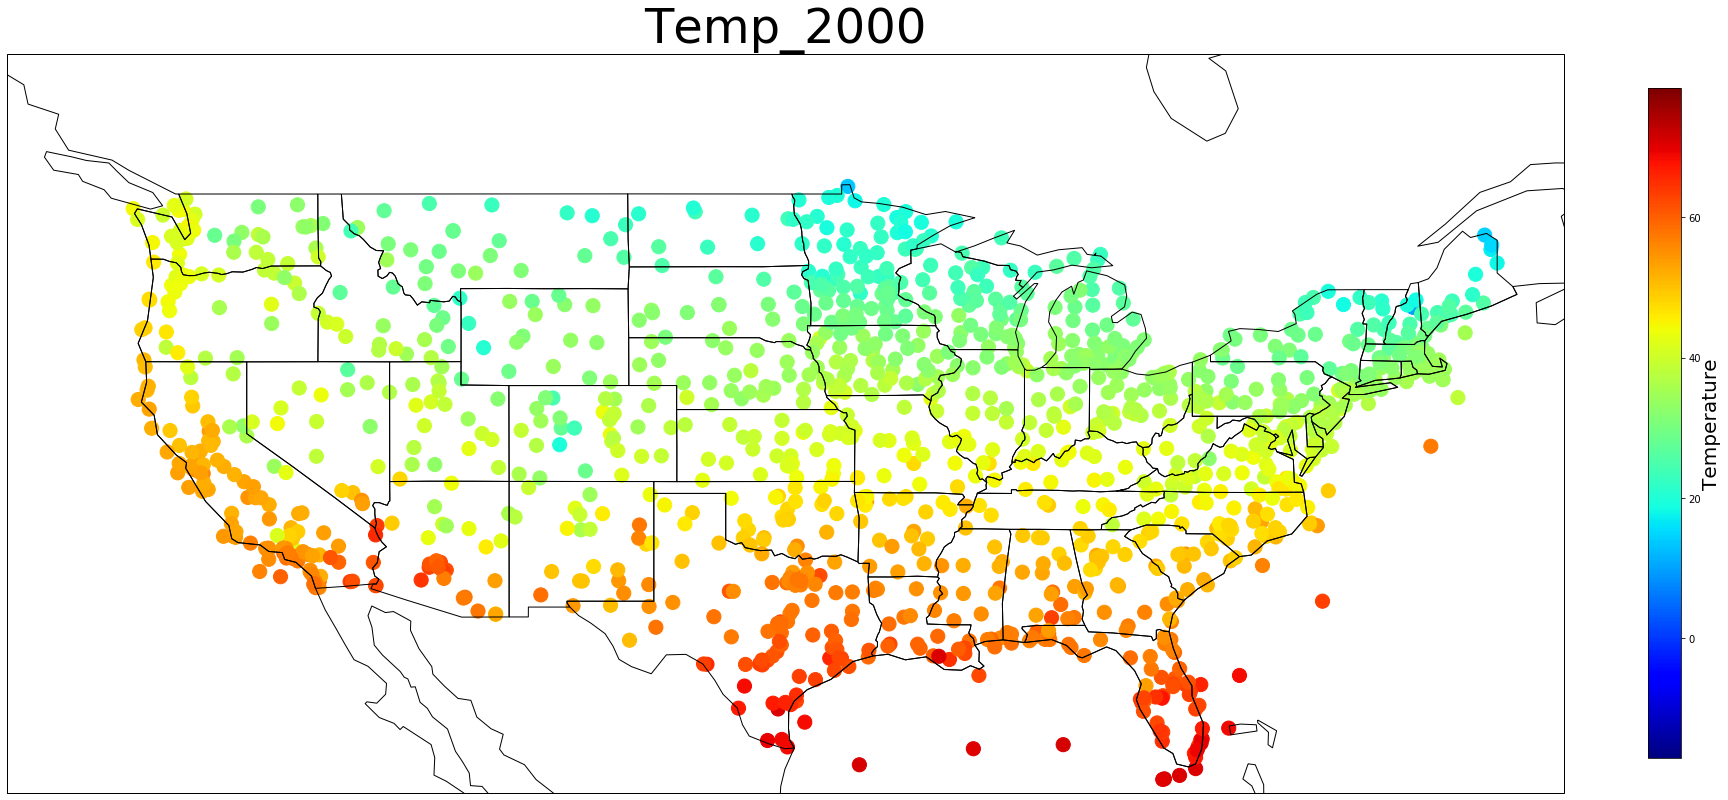

In [220]:
mapplot(gsod2000m1, 'Temp_2000')

In [221]:
gsod2020ll = latlong(gsod2020,stations)

In [222]:
gsod2020m1 = gsod2020ll.loc[gsod2020ll.Month == '05']

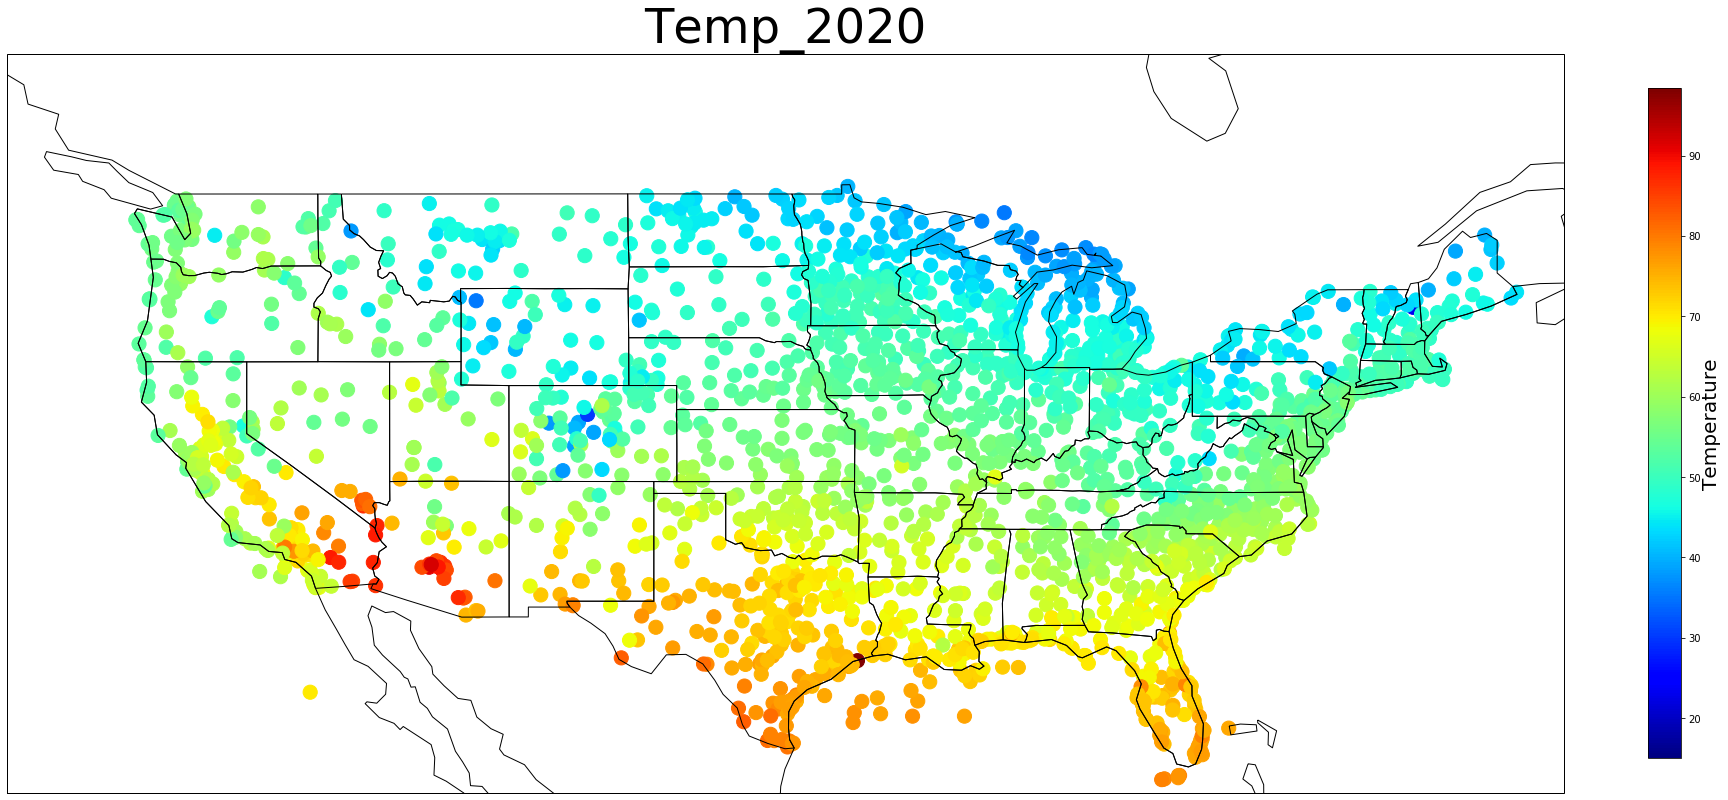

In [223]:
mapplot(gsod2020m1, 'Temp_2020')